In [ ]:
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install evaluate jiwer

In [26]:
from datasets import load_dataset
import numpy as np
from IPython.display import clear_output
from scipy.signal import resample
import matplotlib.pyplot as plt
from transformers import WhisperTokenizer, WhisperFeatureExtractor, WhisperForConditionalGeneration
import torch
import evaluate
from tqdm import tqdm

In [27]:
# WER - Word Error Rate
wer = evaluate.load("wer")

In [28]:
def down_sample_rate_audio(audio_original, original_sample_rate):
  target_sample_rate = 16000

  # Calculate the len of sample for the target sample rate
  len_sample = int(len(audio_original) * target_sample_rate / original_sample_rate)

  # Resample the audio to the target sample rate
  downsampled_audio = resample(audio_original, len_sample)

  return downsampled_audio

In [29]:
def evaluation(model, dataset):
  model.eval()

  predictions = []
  references = []

  for sample in tqdm(dataset, total=len(dataset)):
    audio_sample = sample['audio']['array']
    sample_rate = sample['audio']['sampling_rate']
    text = sample['text']

    audio = down_sample_rate_audio(audio_sample, sample_rate)

    input_features = feature_extractor(raw_speech=audio,
                                  sampling_rate=16000,
                                  return_tensors='pt').input_features

    # Generate predictions with no gradient computation
    with torch.no_grad():
      predicted_ids = model.generate(input_features.to('cuda'), language='english', task='transcribe')

    # Decode predictions
    text_preds = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)

    predictions.append(text_preds[0])
    references.append(text)

  WER = wer.compute(predictions=predictions, references=references)

  return WER

In [30]:
def print_data(model, dataset):
  model.eval()

  for index in range(10):
    target = dataset[index]['text']
    audio_original = dataset[index]['audio']['array']

    input_feature = feature_extractor(raw_speech=audio_original,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
      op = model.generate(input_feature.to('cuda'), language='english', task='transcribe')

    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-----{index}-----')
    print(f'True: {target}')
    print(f'Prediction: {text_pred}')

# Initialize Models

In [31]:
# Transform text to token
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language='english', task='transcribe')

# Feature extractor for getting input feature
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small", language='english', task='transcribe')

# Prediction using Whisper Model
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [32]:
# Train Data
atco_asr_data = load_dataset("jlvdoorn/atco2-asr-atcosim", split="train")

# Select first 200 sample for test
atco_asr_data = atco_asr_data.select(range(200))

# Find out the maximum length of transcription in train dataset

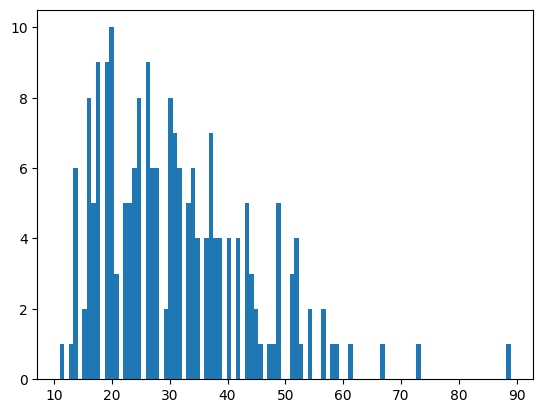

In [33]:
list_of_transcription_len = []

for sample in atco_asr_data:
  text = sample['text']
  tokenized_text = tokenizer(text).input_ids
  list_of_transcription_len.append(len(tokenized_text))

plt.hist(list_of_transcription_len, bins=100)
plt.show()

# Data before training

In [34]:
print('------Before Training------')
print_data(model, atco_asr_data)

------Before Training------
-----0-----
True: Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo 
Prediction:  Oscar Quilopapa Mike Bravo, RISC100
-----1-----
True: Oscar Kilo Kilo Echo Alfa Praha Radar identified climb flight level one hundred IFR flight starts  now time zero five cleared to destination via flight plan route 
Prediction:  Oscar kilo kilo, Eqa, Praha radar identified. Consulate level 100, AFL, now time 05, quick destination, WFL, BenRoot.
-----2-----
True: Ryanair Seven Three Alpha Hotel turn left heading three six zero Ryanair Seven Three Alpha Hotel 
Prediction:  Ryanair 730 hotel on left heading 360 Ryanair 730 hotel
-----3-----
True: Oscar Kilo Kilo Uniform November proceed direct Baltu proceed direct Baltu Oscar Kilo Kilo Uniform November 
Prediction:  Oscar, what did you say in the phone number?
-----4-----
True: Oscar Mike Papa turn right heading zero two zero cleared ILS approach runway zero six speed maximu

# Format data for training

In [35]:
class whisper_training_dataset(torch.utils.data.Dataset):
  def __init__(self, dataset, max_len): # dataset is huggingface dataset object
    self.dataset = dataset
    self.max_len = max_len
    self.bos_token = model.config.decoder_start_token_id

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    item = self.dataset[index]

    # Input Feature
    audio_data = down_sample_rate_audio(item['audio']['array'], item['audio']['sampling_rate'])
    input_features = feature_extractor(raw_speech=audio_data,
                                  sampling_rate=16000,
                                  return_tensors='pt').input_features[0]

    # Process the transcription
    transcription = item['text']

    ## Create labels
    labels = tokenizer(transcription, padding='max_length', max_length=self.max_len, truncation=True, return_tensors='pt')

    # Replace all elements in encoded_target by -100 by position of elements value 0 (not 1) in attention_mask
    labels = labels['input_ids'].masked_fill(labels['attention_mask'].ne(1), -100)

    labels = labels[0][1:]

    return {
        "input_features": input_features,
        "labels": labels,
    }

In [36]:
dataset = whisper_training_dataset(dataset=atco_asr_data, max_len=60)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True
)

# Training

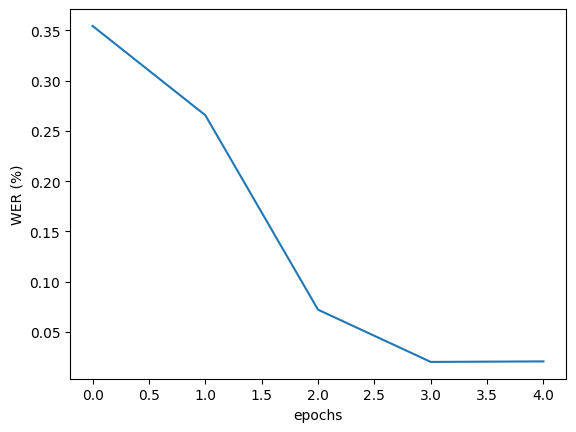

100%|██████████| 5/5 [17:17<00:00, 207.56s/it]


In [37]:
device = 'cuda'
max_epochs = 5
running_wer = []

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# tqdm for showing process
for epoch in tqdm(range(max_epochs)):
  for batch in train_dataloader:

    model.train()   # Train Mode

    input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

    ## FORWARD PASS
    # Calculate loss between input & label
    outputs = model(input_features, labels=labels)
    loss = outputs.loss

    ## BACKWARD PROPAGATION
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()   # Reset gradients

  running_wer.append(evaluation(model, atco_asr_data))

  plt.plot(running_wer)
  clear_output(wait=True)
  plt.xlabel('epochs')
  plt.ylabel('WER (%)')
  plt.show()


# Save Finetuned Model

In [ ]:
torch.save(model.state_dict(), 'finetune_whisper_small.pth')
model.load_state_dict(torch.load('finetune_whisper_small.pth', weights_only=True))
model.eval()  # Evaluation Mode
model.to('cuda')

# After Training

In [39]:
print('------After Training------')
print_data(model, atco_asr_data)

------After Training------
-----0-----
True: Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo 
Prediction: Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo 
-----1-----
True: Oscar Kilo Kilo Echo Alfa Praha Radar identified climb flight level one hundred IFR flight starts  now time zero five cleared to destination via flight plan route 
Prediction: Oscar Kilo Kilo Echo Alfa Praha Radar identified climb flight level one hundred IFR flight starts  now time zero five cleared to destination via flight plan route 
-----2-----
True: Ryanair Seven Three Alpha Hotel turn left heading three six zero Ryanair Seven Three Alpha Hotel 
Prediction: Ryanair Seven Three Alpha Hotel turn left heading three six zero Ryanair Seven Three Alpha Hotel 
-----3-----
True: Oscar Kilo Kilo Uniform November proceed direct Baltu proceed direct Baltu Oscar Kilo Kilo Uniform November 
Prediction: Oscar Ki